In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Alex Mallen (atmallen@uw.edu)
"""

import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import time

from torch import optim
from torch.fft import fftn, fftfreq

from dpk import model_objs

seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

# generate toy data with periodic uncertainty
T = 10_000
t = np.linspace(0, 100 * np.pi, T)
mu_t = (1.2 + np.sin(-t) + np.cos(4 * t))
sigma_t = 0.3 * np.cos(t) + 0.8
data = np.random.normal(mu_t, sigma_t)
# normalize the data
scale = np.std(data)
loc = np.mean(data)
x = (data - loc) / scale
x = torch.Tensor(x.reshape(-1, 1))

periods = [200.0, 50.0]
omegas = [2 * np.pi / p for p in periods]
omega_dim = len(omegas)
# define a model
l1width = 1024
l2width = 1024
wd = 1e-3
lrt = 1e-3
model_obj = model_objs.NormalNLL(x_dim=x.shape[1], num_freqs=len(periods), n=l1width, n2=l2width)
# model_obj = model_objs.SkewNormalNLL(x_dim=x.shape[1], num_freqs=len(periods), n=l1width, n2=l2width)
# model_obj = model_objs.DeterministicMSE(x_dim=x.shape[1], num_freqs=len(periods), n=l1width, n2=l2width)

[ Using Seed :  633  ]


In [13]:
def get_loss(x, t_idxs):
    batch_size = len(t_idxs)
    print("1:", time.time() - start_time)
    m, s = model_obj.decode(inpts)
    print("2:", time.time() - start_time)
    m, s = m.squeeze(), s.squeeze()
    losses = ((x - m) ** 2 / (2 * s ** 2) + torch.log(s)).squeeze()
    
    print("3:", time.time() - start_time)
    L = losses.reshape((batch_size,) + (K,) * omega_dim)  # (batch_size, K, ..., K)

    dims = tuple(range(-omega_dim, 0))
    Lft = fftn(L, dim=dims)
    print("4:", time.time() - start_time)

    # find frequency associated with each element of Lft
    freqs = fftfreq(K) / T
    F = torch.meshgrid(*(freqs for _ in range(omega_dim)), indexing="ij")
    t_vec = (t_idxs + 1).reshape((batch_size,) + (1,) * omega_dim)
    F = [f.reshape((1,) + f.shape) * t_vec for f in F]


    # ifft is the weighted sum of complex exponentials of frequency `F`
    ifft_coefs = torch.exp(complex("j") * (sum(F[i] * omegas[i] * K * T for i in range(omega_dim))))
    print("5:", time.time() - start_time)
    complex_loss = torch.sum(Lft * ifft_coefs) / (T * K**omega_dim)  
    print("6:", time.time() - start_time)
    # print("complex loss", complex_loss)
    loss = torch.real(complex_loss)  # take only real part (imag should be near 0)
    return loss


In [14]:
K = 12  # number of points within a period of the error surface to use
two_pi_linspace = torch.arange(0, K) * 2 * np.pi / K
two_pi_linspaces = torch.meshgrid(*((two_pi_linspace,) * omega_dim), indexing="ij")
flatteneds = [l.reshape(l.numel()) for l in two_pi_linspaces]
two_pi_block = torch.stack(flatteneds).T
two_pi_block
inpts = torch.cat([torch.cos(two_pi_block)] * 2 + [torch.sin(two_pi_block)] * 2, -1)

opt = optim.SGD(model_obj.parameters(), lr=3e-3)

num_epochs = 100
train_losses = []
times = []
start_time = time.time()



# train the model
for epoch in range(num_epochs):
    batches = torch.randperm(T)
    batch_size = 1024
    for itr in range(len(batches) // batch_size):
        opt.zero_grad()
        
        t_idxs = batches[batch_size * itr:batch_size * (itr + 1)]
        loss = get_loss(x[t_idxs], t_idxs)
        # print(loss.detach().numpy())

        grad = loss.backward()
        print("7:", time.time() - start_time)
        train_losses.append(loss.detach())
        times.append(time.time() - start_time)
        # print(itr, train_losses[-1])
        opt.step()
        print("8:", time.time() - start_time)

1: 0.0
2: 0.017992258071899414
3: 0.01899886131286621
4: 0.02099752426147461
5: 0.027006149291992188
6: 0.02899932861328125
7: 0.06599140167236328
8: 0.06915998458862305
1: 0.07000303268432617
2: 0.0879979133605957
3: 0.09000658988952637
4: 0.09100055694580078
5: 0.09698987007141113
6: 0.09799623489379883
7: 0.13318657875061035
8: 0.13627386093139648
1: 0.13822102546691895
2: 0.15519356727600098
3: 0.15619206428527832
4: 0.15819191932678223
5: 0.1641855239868164
6: 0.1651902198791504
7: 0.2001955509185791
8: 0.2022395133972168
1: 0.20507192611694336
2: 0.22215485572814941
3: 0.22315168380737305
4: 0.22515463829040527
5: 0.230147123336792
6: 0.23215055465698242
7: 0.2711524963378906
8: 0.27416276931762695
1: 0.2761979103088379
2: 0.2941420078277588
3: 0.2951469421386719
4: 0.29614853858947754
5: 0.302142858505249
6: 0.3031487464904785
7: 0.34014320373535156
8: 0.3421776294708252
1: 0.3441579341888428
2: 0.35443854331970215
3: 0.35443854331970215
4: 0.35443854331970215
5: 0.3544385433197

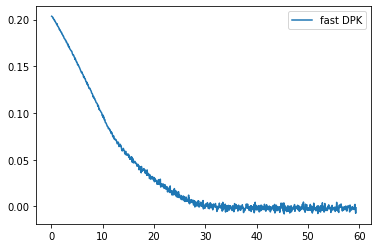

In [15]:
plt.plot(times, train_losses, label="fast DPK")
plt.legend()

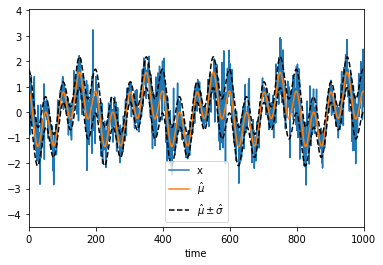

In [16]:
plt.plot(x, label="x")
omega_ts = torch.stack([torch.arange(len(x)) * omega for omega in omegas]).T
forecast_inpts = torch.cat([torch.cos(omega_ts)] * 2 + [torch.sin(omega_ts)] * 2, -1)  # todo: generalize to more omegas
params = model_obj.output(forecast_inpts)
mean_hat = model_obj.mean(params)
std_hat = model_obj.std(params)
plt.plot(mean_hat, label="$\hat \mu$")
plt.plot(mean_hat + std_hat, "--k", label="$\hat \mu \pm \hat \sigma$")
plt.plot(mean_hat - std_hat, "--k")
plt.xlabel("time")
plt.xlim([0, 1000])
plt.legend()
plt.show()

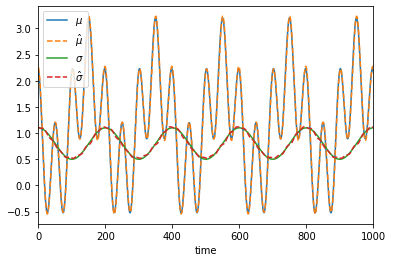

In [21]:
plt.plot(mu_t, label="$\mu$")
plt.plot(scale * mean_hat + loc, "--", label="$\hat \mu$")
plt.plot(sigma_t, label="$\sigma$")
plt.plot(scale * std_hat, "--", label="$\hat \sigma$")
plt.xlabel("time")
plt.xlim([0, 1000])
plt.legend()
plt.show()

In [7]:
import torch
print(torch.cuda.device_count())
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import numpy as np

n1 = 13
n2 = 24
n_chan = 64

class flowNet(nn.Module):
    
    def __init__(self, num_freqs):
        
        super(flowNet, self).__init__()
        
        self.l1 = nn.Linear(2*num_freqs, 128)
        self.l2 = nn.Linear(128, 256)
        self.l3 = nn.Linear(256, n1*n2)
        self.c1 = nn.Conv2d(1, 8, 3)
        
        self.block1 = nn.Sequential(nn.ConvTranspose2d(8,n_chan,3, stride = 2),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh())
        
        self.block2 = nn.Sequential(nn.ConvTranspose2d(n_chan,n_chan,3, stride = 2),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh())
        
        self.block3 = nn.Sequential(nn.ConvTranspose2d(n_chan,n_chan, 3, stride = 2),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh())
        
        self.block4 = nn.Sequential(nn.ConvTranspose2d(n_chan,n_chan,3, stride = 2),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh())
        
        self.block5 = nn.Sequential(nn.ConvTranspose2d(n_chan,n_chan,3, stride = 2),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, n_chan, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(n_chan, 8, 3, padding = 1),
                                    nn.Tanh())
        
        self.block6 = nn.Sequential(nn.ConvTranspose2d(8,8,3, stride = 2),
                                    nn.Tanh(),
                                    nn.Conv2d(8, 8, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(8, 8, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(8, 8, 3, padding = 1),
                                    nn.Tanh(),
                                    nn.Conv2d(8, 1, 3, padding = 1))
        
        
    def forward(self, x):
        
        x = nn.Tanh()(self.l1(x))
        x = nn.Tanh()(self.l2(x))
        x = nn.Tanh()(self.l3(x)).reshape((-1,1,n1,n2))
        x = nn.Tanh()(self.c1(x))
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)[:,0,23:-23, 15:-16]
        
        return x

0


In [9]:
fn = flowNet(6)
sum(p.numel() for p in fn.parameters())

606713

In [ ]:
    
data = torch.from_numpy(np.log(np.load('nvif/for_henning.npy'))+25.)/2.5
data = data.cuda()
inpt = torch.from_numpy(np.random.uniform(-1,1,(4,12)).astype(np.float32)).cuda()
fn = flowNet(6).cuda()

learning_rate = 3e-4
optimizer = torch.optim.Adam(fn.parameters(), lr=learning_rate)

for i in range(300):
    x = fn(inpt)
    loss = torch.mean((data-x)**2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(i, loss)

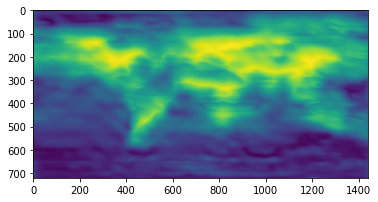

In [ ]:
x = x.detach().cpu().numpy()
plt.imshow(np.flipud(x[0]))